# ONNX graph, single or double floats

The notebook shows discrepencies obtained by using double floats instead of single float in two cases. The second one involves [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Simple case of a linear regression

A linear regression is simply a matrix multiplication followed by an addition: $Y=AX+B$. Let's train one with [scikit-learn](https://scikit-learn.org/stable/).

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
data = load_boston()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [3]:
clr.score(X_test, y_test)

0.77265840833068

In [4]:
clr.coef_

array([-1.15252395e-01,  4.88204037e-02, -8.41963443e-03,  2.59331874e+00,
       -2.06335208e+01,  4.04718591e+00, -2.11526920e-03, -1.65794672e+00,
        2.84796430e-01, -9.98951697e-03, -9.90364341e-01,  1.03828254e-02,
       -4.68964825e-01])

In [5]:
clr.intercept_

36.835989825553355

Let's predict with *scikit-learn* and *python*.

In [6]:
ypred = clr.predict(X_test)
ypred[:5]

array([23.62794378, 21.20532332, 27.58860225, 18.6063024 , 15.93082815])

In [7]:
py_pred = X_test @ clr.coef_ + clr.intercept_
py_pred[:5]

array([23.62794378, 21.20532332, 27.58860225, 18.6063024 , 15.93082815])

In [8]:
clr.coef_.dtype, clr.intercept_.dtype

(dtype('float64'), dtype('float64'))

## With ONNX

With *ONNX*, we would write this operation as follows... We still need to convert everything into single floats = float32.

In [9]:
%load_ext mlprodict

In [10]:
from skl2onnx.algebra.onnx_ops import OnnxMatMul, OnnxAdd
import numpy

onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float32)),
                   numpy.array([clr.intercept_]),
                   output_names=['Y'])
onnx_model32 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float32)},
                              dtype=numpy.float32)

# add -l 1 if nothing shows up
%onnxview onnx_model32

The next line uses a python runtime to compute the prediction.

In [11]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(onnx_model32)
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([23.627945, 21.205326, 27.588604, 18.606304, 15.930832],
      dtype=float32)

And here is the same with [onnxruntime](https://github.com/microsoft/onnxruntime)...

In [12]:
oinf = OnnxInference(onnx_model32, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([23.627945, 21.205326, 27.588604, 18.606304, 15.930832],
      dtype=float32)

## With double instead of single float

[ONNX](https://onnx.ai/) was originally designed for deep learning which usually uses floats but it does not mean cannot be used. Every number is converted into double floats.

In [13]:
onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float64)),
                   numpy.array([clr.intercept_]),
                   output_names=['Y'])
onnx_model64 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float64)},
                              dtype=numpy.float64)

And now the *python* runtime...

In [14]:
oinf = OnnxInference(onnx_model64)
ort_pred = oinf.run({'X': X_test})['Y']
ort_pred[:5]

array([23.62794378, 21.20532332, 27.58860225, 18.6063024 , 15.93082815])

And the *onnxruntime* version of it, not fully supportive of double yet...

In [15]:
try:
    oinf = OnnxInference(onnx_model64, runtime="onnxruntime1")
    ort_pred = oinf.run({'X': X_test.astype(numpy.float64)})['Y']
    ort_pred[:5]
except RuntimeError as e:
    print(e)

## And now the GaussianProcessRegressor

This shows a case

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
gau = GaussianProcessRegressor(alpha=10, kernel=DotProduct())
gau.fit(X_train, y_train)

GaussianProcessRegressor(alpha=10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [17]:
from mlprodict.onnx_conv import to_onnx
onnxgau32 = to_onnx(gau, X_train.astype(numpy.float32), dtype=numpy.float32)
oinf32 = OnnxInference(onnxgau32, runtime="python")
ort_pred32 = oinf32.run({'X': X_test.astype(numpy.float32)})['GPmean']
numpy.squeeze(ort_pred32)[:25]

array([24.375  , 20.625  , 28.5    , 18.3125 , 18.15625, 15.5    ,
       40.40625, 21.0625 , 17.5    , 16.25   , 18.625  , 23.5    ,
       20.875  , 16.8125 , 18.75   , 25.375  , 21.84375, 27.75   ,
       14.75   , 31.65625, 20.40625, 21.9375 , 26.5    , 13.53125,
       34.15625], dtype=float32)

In [18]:
onnxgau64 = to_onnx(gau, X_train.astype(numpy.float64), dtype=numpy.float64)
oinf64 = OnnxInference(onnxgau64, runtime="python")
ort_pred64 = oinf64.run({'X': X_test.astype(numpy.float64)})['GPmean']
numpy.squeeze(ort_pred64)[:25]

array([24.68275083, 20.17216288, 28.4280004 , 18.16998445, 18.26424628,
       16.07043206, 40.59617799, 20.4861235 , 17.96905057, 16.24325372,
       19.01950901, 23.65422543, 20.54061589, 16.83765505, 18.85620332,
       25.66149306, 21.4924616 , 27.50628927, 14.67275618, 31.56870577,
       20.16713281, 21.42304151, 26.96992261, 13.81531227, 34.04079153])

The differences between the predictions for single floats and double floats...

In [19]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - ort_pred64)))[-5:]

array([0.47186822, 0.51445849, 0.52629847, 0.5763765 , 0.70492867])

Who's right or wrong... The differences between the predictions with the original model...

In [20]:
pred = gau.predict(X_test.astype(numpy.float64))

In [21]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - pred)))[-5:]

array([0.47186822, 0.51445849, 0.52629847, 0.5763765 , 0.70492867])

In [22]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred64 - pred)))[-5:]

array([0., 0., 0., 0., 0.])

Double predictions clearly wins.

In [23]:
# add -l 1 if nothing shows up
%onnxview onnxgau64

## Saves...

Let's keep track of it.

In [24]:
with open("gpr_dot_product_boston_32.onnx", "wb") as f:
    f.write(onnxgau32.SerializePartialToString())
from IPython.display import FileLink
FileLink('gpr_dot_product_boston_32.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_32.onnx

In [25]:
with open("gpr_dot_product_boston_64.onnx", "wb") as f:
    f.write(onnxgau64.SerializePartialToString())
FileLink('gpr_dot_product_boston_64.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_64.onnx

## Side by side

We may wonder where the discrepencies start. But for that, we need to do a side by side.

In [26]:
from mlprodict.onnxrt.validate.side_by_side import side_by_side_by_values
sbs = side_by_side_by_values([(oinf32, {'X': X_test.astype(numpy.float32)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])

from pandas import DataFrame
df = DataFrame(sbs)
# dfd = df.drop(['value[0]', 'value[1]', 'value[2]'], axis=1).copy()
df

,metric,step,v[0],v[1],cmp,name,value[0],shape[0],value[1],shape[1]
0,nb_results,-1,10,1.000000e+01,OK,NaN,NaN,NaN,NaN,NaN
1,abs-diff,0,0,4.893252e-08,OK,X,"[[0.06263, 0.0, 11.93, 0.0, 0.573, 6.593, 69.1...","(127, 13)","[[0.06263, 0.0, 11.93, 0.0, 0.573, 6.593, 69.1...","(127, 13)"
2,abs-diff,1,0,2.615161e-02,e<0.1,GPmean,"[[24.375, 20.625, 28.5, 18.3125, 18.15625, 15....","(1, 127)","[[24.682750829830184, 20.17216288333293, 28.42...","(1, 127)"
3,abs-diff,2,0,5.553783e-08,OK,kgpd_MatMulcst,"[[0.29819, 11.0874, 0.08221, 0.12802, 0.62356,...","(13, 379)","[[0.29819, 11.0874, 0.08221, 0.12802, 0.62356,...","(13, 379)"
4,abs-diff,3,0,2.569000e-08,OK,kgpd_Addcst,[705.79395],"(1,)",[705.7939634443445],"(1,)"
5,abs-diff,4,0,5.295014e-08,OK,gpr_MatMulcst,"[1.067651, -0.3897476, 0.4001843, -0.28861365,...","(379,)","[1.0676510043582548, -0.3897476028987512, 0.40...","(379,)"
6,abs-diff,5,0,0.000000e+00,OK,gpr_Addcst,[[0.0]],"(1, 1)",[[0.0]],"(1, 1)"
7,abs-diff,6,0,2.003658e-07,OK,kgpd_Y0,"[[234216.27, 315237.94, 243189.44, 267891.22, ...","(127, 379)","[[234216.25805194405, 315237.96387384634, 2431...","(127, 379)"
8,abs-diff,7,0,2.003658e-07,OK,kgpd_C0,"[[234216.27, 315237.94, 243189.44, 267891.22, ...","(127, 379)","[[234216.25805194405, 315237.96387384634, 2431...","(127, 379)"
9,abs-diff,8,0,2.003658e-07,OK,kgpd_output0,"[[234216.27, 315237.94, 243189.44, 267891.22, ...","(127, 379)","[[234216.25805194405, 315237.96387384634, 2431...","(127, 379)"


The differences really starts for output ``'O0'`` after the matrix multiplication. This matrix melts different number with very different order of magnitudes and that alone explains the discrepencies with doubles and floats on that particular model.

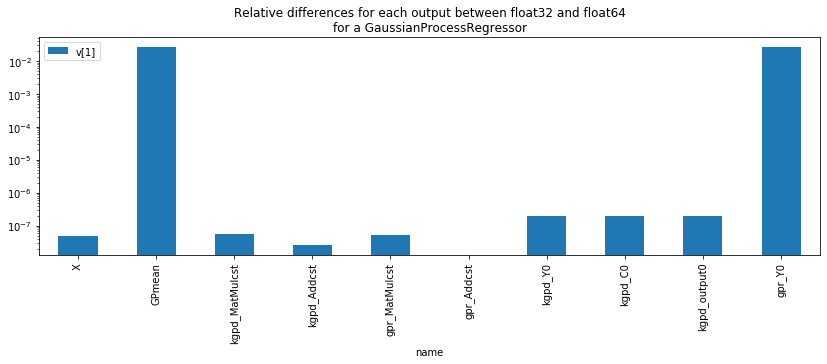

In [27]:
%matplotlib inline
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float32 and float64\nfor a GaussianProcessRegressor");

Before going further, let's check how sensitive the trained model is about converting double into floats.

In [28]:
pg1 = gau.predict(X_test)
pg2 = gau.predict(X_test.astype(numpy.float32).astype(numpy.float64))
numpy.sort(numpy.sort(numpy.squeeze(pg1 - pg2)))[-5:]

array([1.51888526e-06, 1.52538996e-06, 1.53196743e-06, 1.70313433e-06,
       1.89113780e-06])

Having float or double inputs should not matter. We confirm that with the model converted into ONNX.

In [29]:
p1 = oinf64.run({'X': X_test})['GPmean']
p2 = oinf64.run({'X': X_test.astype(numpy.float32).astype(numpy.float64)})['GPmean']
numpy.sort(numpy.sort(numpy.squeeze(p1 - p2)))[-5:]

array([1.51888526e-06, 1.52538996e-06, 1.53196743e-06, 1.70313433e-06,
       1.89113780e-06])

Last verification.

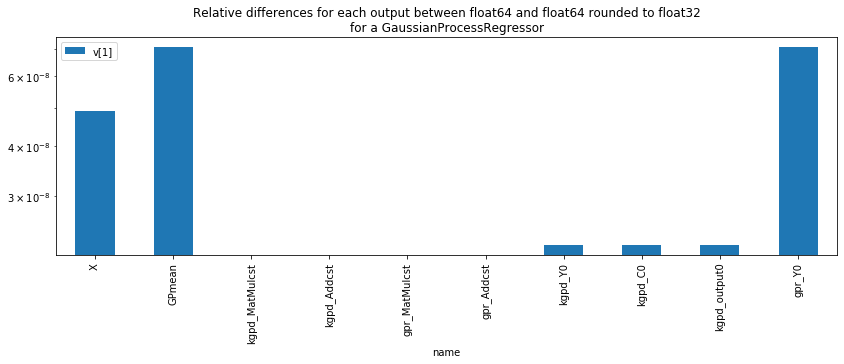

In [30]:
sbs = side_by_side_by_values([(oinf64, {'X': X_test.astype(numpy.float32).astype(numpy.float64)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])
df = DataFrame(sbs)
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float64 and float64 rounded to float32"
             "\nfor a GaussianProcessRegressor");